In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
#import xlrd
#çok fazla veri var, fit etmek çok uzun sürdüğü için chunksize ekliyorum
#2009 2011 arası 1milyona yakın veri var bilgisayar bunun için yeterli değildi
#bu nedenle sadece 2009 2010 arası verileri kullandım

file_path = '/content/drive/MyDrive/Year 2009-2010.csv'

def load_data(file_path,size):
  data = pd.read_csv(file_path,encoding='unicode_escape',nrows=size)
  return data

In [ ]:
data = load_data(file_path, size=200000)

In [ ]:
def check_data(data):
  print(data.info())
  print(100*'%')
  print(data.head())
  print(100*'%')
  print(data.isnull().sum())

In [ ]:
check_data(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136909 entries, 0 to 136908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      136909 non-null  object 
 1   StockCode    136909 non-null  object 
 2   Description  135723 non-null  object 
 3   Quantity     136909 non-null  int64  
 4   InvoiceDate  136909 non-null  object 
 5   Price        136909 non-null  float64
 6   Customer ID  102683 non-null  float64
 7   Country      136908 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 8.4+ MB
None
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434   

           Recency    Frequency       Monetary
count  2012.000000  2012.000000    2012.000000
mean     43.229622     2.331014    1082.991913
std      35.269735     3.177615    4232.287601
min       1.000000     1.000000       1.300000
25%      15.000000     1.000000     232.525000
50%      32.000000     1.000000     422.700000
75%      64.000000     2.000000     907.145000
max     115.000000    45.000000  114492.840000


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Segmentlerin Özellikleri:
            Recency  Frequency      Monetary  Count
Cluster                                           
0        18.073394   7.311927   4745.521505    109
1         6.250000  28.500000  82952.700000      4
2        44.967161   1.875000    582.246406   1888
3         7.727273  21.727273  20965.988182     11
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


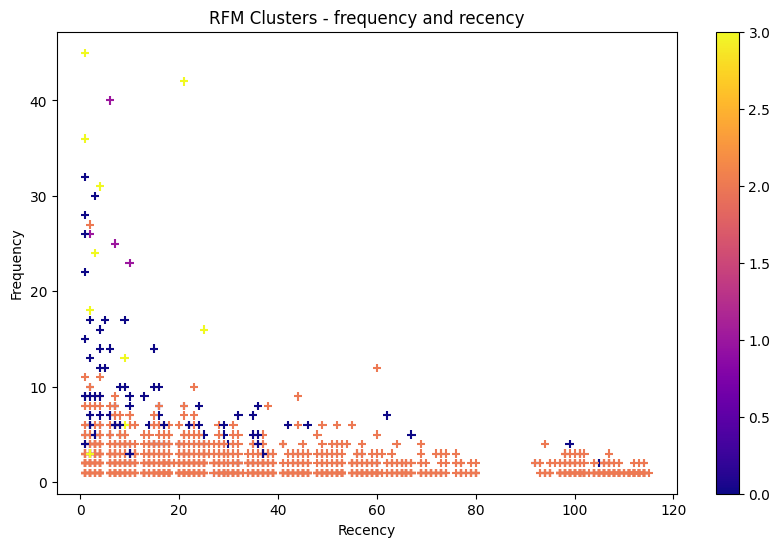

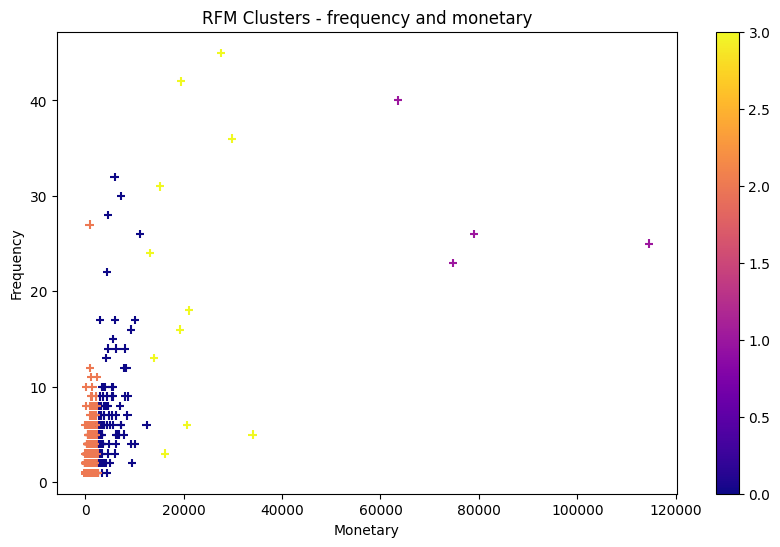

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
 RMSE: 8.571996500688114


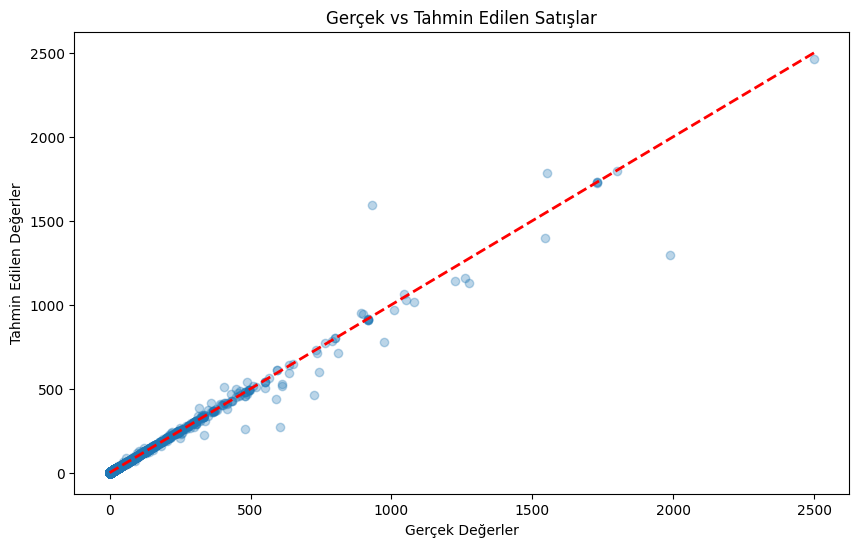

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


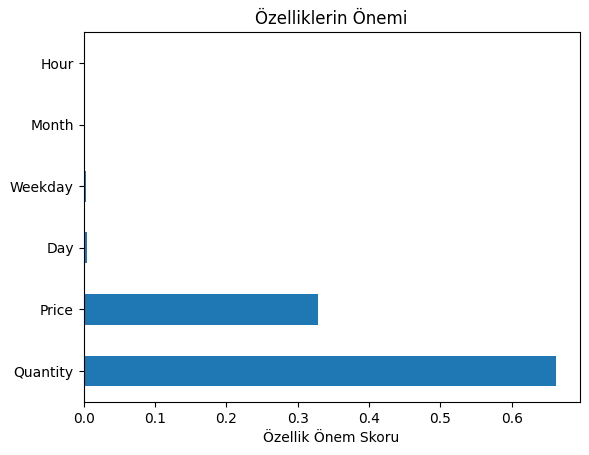

Özellik Önem Skorları:
 Month       0.002070
Day         0.004099
Weekday     0.002871
Hour        0.001337
Quantity    0.661856
Price       0.327768
dtype: float64


In [ ]:
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Veri temizleme
def preprocess_data(data):
    data_cleaned = data.dropna()
    data_cleaned = data_cleaned[data_cleaned['Quantity'] > 0]
    price_upper_limit = data_cleaned['Price'].quantile(0.99)
    data_cleaned = data_cleaned[(data_cleaned['Price'] > 0) & (data_cleaned['Price'] < price_upper_limit)]
    data_cleaned = data_cleaned[~data_cleaned['Invoice'].astype(str).str.startswith('C')]
    return data_cleaned

# RFM hesaplama
def calculate_rfm(data):
    data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
    data['TotalPrice'] = data["Price"] * data["Quantity"]
    # 1 gün sonra diyelim analiz zamanına
    analysis_date = data['InvoiceDate'].max() + pd.DateOffset(1)

    rfm = data.groupby('Customer ID').agg({
        'InvoiceDate': lambda x: (analysis_date - x.max()).days,
        'Invoice': 'nunique',
        'TotalPrice': 'sum'
    }).rename(columns={
        'InvoiceDate': 'Recency',
        'Invoice': 'Frequency',
        'TotalPrice': 'Monetary'
    })
    rfm = rfm[rfm["Monetary"] > 0]

    print(rfm.describe())

    return rfm

# KMeans ile segmentasyon
def kmeans_segmentation(rfm, n_clusters=4):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    rfm['Cluster'] = kmeans.fit_predict(rfm)
    return rfm, kmeans

# Segmentleri tanımlama
def describe_segments(rfm):
    segments = rfm.groupby('Cluster').agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': 'mean',
        'Cluster': 'count'
    }).rename(columns={'Cluster': 'Count'})

    return segments

# RFM segmentlerini görselleştirme
def plot_rfm_clusters(rfm):
    plt.figure(figsize=(10, 6))
    plt.scatter(rfm['Recency'], rfm['Frequency'], c=rfm['Cluster'], cmap='plasma', marker='+')
    plt.title('RFM Clusters - frequency and recency')
    plt.xlabel('Recency')
    plt.ylabel('Frequency')
    plt.colorbar()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.scatter(rfm['Monetary'], rfm['Frequency'], c=rfm['Cluster'], cmap='plasma', marker='+')
    plt.title('RFM Clusters - frequency and monetary')
    plt.xlabel('Monetary')
    plt.ylabel('Frequency')
    plt.colorbar()
    plt.show()

################################################################################

# Özelliklerin eklenmesi
def create_features(data):
    data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
    data['Month'] = data['InvoiceDate'].dt.month
    data['Day'] = data['InvoiceDate'].dt.day
    data['Weekday'] = data['InvoiceDate'].dt.weekday
    data['Hour'] = data['InvoiceDate'].dt.hour
    data['TotalPrice'] = data["Price"] * data["Quantity"]
    return data

# Eğitim ve test verisi bölme
def train_test_split_data(data):
    X = data[['Month', 'Day', 'Weekday', 'Hour', 'Quantity', 'Price']]
    y = data['TotalPrice']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

# Random Forest modelini eğitme
def train_random_forest(X_train, y_train):
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    return rf

# Modeli değerlendirme
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse, y_pred

# Sonuçları görselleştirme
def plot_results(y_test, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
    plt.xlabel('Gerçek Değerler')
    plt.ylabel('Tahmin Edilen Değerler')
    plt.title('Gerçek vs Tahmin Edilen Satışlar')
    plt.show()

# Özellik önemlerini görselleştirme
def plot_feature_importances(model, feature_names):
    feature_importances = pd.Series(model.feature_importances_, index=feature_names)
    feature_importances.sort_values(ascending=False).plot(kind='barh')
    plt.xlabel('Özellik Önem Skoru')
    plt.title('Özelliklerin Önemi')
    plt.show()
    return feature_importances

def main(file_path):
    # Veri ön işleme
    data_cleaned = preprocess_data(data)

    # RFM Analizi ve Müşteri Segmentasyonu
    rfm = calculate_rfm(data_cleaned)
    rfm, kmeans = kmeans_segmentation(rfm, n_clusters=4)

    print(100*'%')
    print(100*'%')

    print("Segmentlerin Özellikleri:\n", describe_segments(rfm))

    print(100*'%')
    print(100*'%')

    plot_rfm_clusters(rfm)

    print(100*'%')
    print(100*'%')

    # Satış Tahmini
    data_with_features = create_features(data_cleaned)
    X_train, X_test, y_train, y_test = train_test_split_data(data_with_features)
    rf_model = train_random_forest(X_train, y_train)
    rmse, y_pred = evaluate_model(rf_model, X_test, y_test)
    print(f" RMSE: {rmse}")
    plot_results(y_test, y_pred)

    print(100*'%')
    print(100*'%')

    # Özelliklerin Önemi
    feature_importances = plot_feature_importances(rf_model, X_train.columns)
    print("Özellik Önem Skorları:\n", feature_importances)

# Ana fonksiyonu çalıştırma
main(file_path)